## Devito CFD Tutorial series

The following series of notebook tutorials will demonstrate the use of Devito and it's SymPy-based API to solve a set of classic examples from Computational Fluid Dynamics (CFD). The tutorials are based on the excellent tutorial series _CFD Python: 12 steps to Navier-Stokes_ by Lorena Barba and focus on the implementation with Devito rather than pure CFD or finite difference theory. For a refresher on how to implement 2D finite difference solvers for CFD problems, please see the original tutorial series here: <br>
http://lorenabarba.com/blog/cfd-python-12-steps-to-navier-stokes/

### Example 1: Linear convection in 2D

Lets start with a simple 2D convection example - step 5 in the original blog. This will already allow us to demonstrate a lot about the use of Devito's symbolic data objects and how to use them to build a simple operator directly from the symbolic notation of the equation. The governing equation we will implement in this tutorial is:

$$\frac{\partial u}{\partial t}+c\frac{\partial u}{\partial x} + c\frac{\partial u}{\partial y} = 0$$

In order to implement this equation we first discretize it using forward differences in time and backward differences in space. Just as the original tutorial, we will use $u_{i,j}^n$ to denote a finite difference stencil point with $i$ and $j$ denoting spatial indices and $n$ denoting the time index. So, after re-arragning the discretized equation for the forward stencil point in time we get 

$$u_{i,j}^{n+1} = u_{i,j}^n-c \frac{\Delta t}{\Delta x}(u_{i,j}^n-u_{i-1,j}^n)-c \frac{\Delta t}{\Delta y}(u_{i,j}^n-u_{i,j-1}^n)$$

Using this, we can start deriving the computational stencil for this equation. Let's first look at the original _pure Python_ implmenentation of the linear convection flow - but first we import our tools and define some parameters:

In [1]:
from examples.cfd import plot_field, init_hat, init_smooth
import numpy as np
%matplotlib inline

# Some variable declarations
nx = 81
ny = 81
nt = 100
c = 1.
dx = 2. / (nx - 1)
dy = 2. / (ny - 1)
sigma = .2
dt = sigma * dx

**A small note on style:** Throughout this tutorial series we will use utility functions to plot the various 2D functions and data sets we deal with. These are all taken from the original tutorial series, but have been slightly modified for our purposes. One of the differences readers might find is that the original series uses _(y, x)_ indexing for 2d data arrays, whereas many of the examples have been adapted to use _(x, y)_ notation in our tutorials.

So, let's start by creating a simple 2D function and initialising it with a "hat function". We will use that initialisation function a lot, so it comes from our utility scripts:

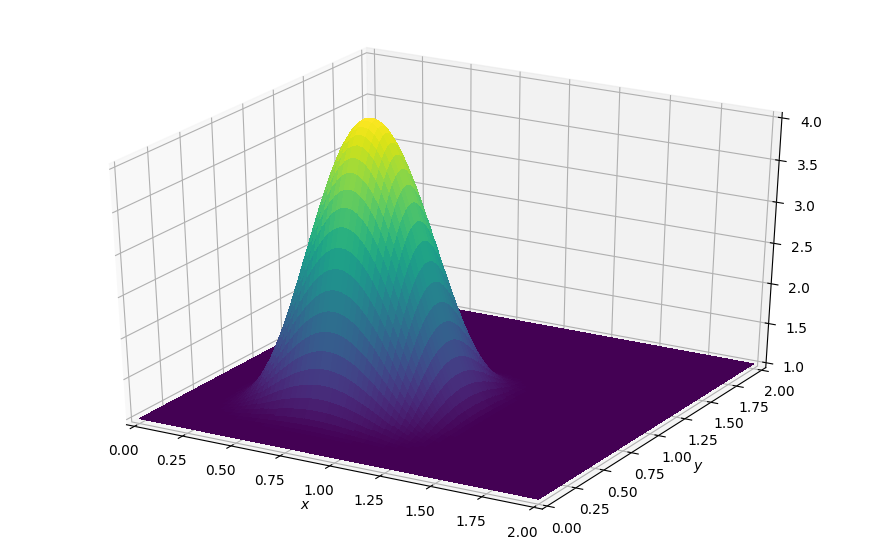

In [2]:
# Create field and assign initial conditions
u = np.empty((nx, ny))
init_smooth(field=u, dx=dx, dy=dy)

# Plot initial condition
plot_field(u, zmax=4.)

Now we can repeat the _pure NumPy_ solve from the original tutorial, where we use NumPy array operations to speed up the computation. Note that we skip the derivation of the stencil used to implement our convection equation, as we are going to walk though this process using the Devito API later in this tutorial.

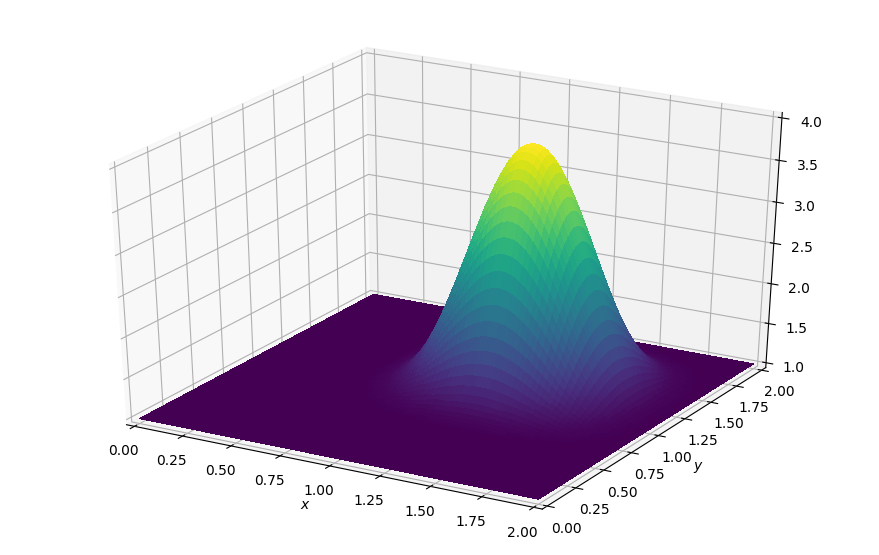

In [3]:
# Repeat initialisation, so we can re-run the cell
init_smooth(field=u, dx=dx, dy=dy)

for n in range(nt + 1):
    # Copy previous result into a new buffer
    un = u.copy()
    
    # Update the new result with a 3-point stencil
    u[1:, 1:] = (un[1:, 1:] - (c * dt / dx * (un[1:, 1:] - un[1:, :-1])) -
                              (c * dt / dy * (un[1:, 1:] - un[:-1, 1:])))

    # Apply boundary conditions
    u[0, :] = 1.
    u[-1, :] = 1.
    u[:, 0] = 1.
    u[:, -1] = 1.

plot_field(u, zmax=4.)

# A small sanity check for auto-testing
assert (u[45:55, 45:55] > 1.8).all()
u_ref = u.copy()

Hooray, the wave moved! Now, this little example is already very concise from a notational point of view and it teaches us quite a few key points about how to perform finite difference stencil computation via NumPy:
* Due to the backward differencing scheme in space (more later) we use only three stencil point in this example:  $u^{n}_{i, j}$, $u^{n}_{i-1, j}$ and $u^{n}_{i, j-1}$. These can be identified in the code through the array indices and correspond to `un[1:, 1:]`, `un[:-1, 1:]` and `un[1:, :-1]` respectively. 
* Two buffers for array data are used throughout: `un[...]` is read from, while `u[...]` is updated, where the line `un = u.copy()` performs a deep copy of the field to switch buffers between timesteps. Note that in some other finite difference tutorials the cost of this copy operation is sometimes amortised by using two pre-allocated buffers and switching the indices of them explicitly.   
* The final four lines within the loop code show us how to implmement simple Dirichlet boundary condition by simply setting a value on the outermost rows and columns of our cartesian grid.

#### Devito implementation
Now we want to re-create the above example via a Devito operator. To do this, we can start by defining our function `u` as a symbolic function object of type `devito.TimeData`. The core thing to note here is that this is one of Devito's symbolic data objects, which have a dual role in the creation of finite difference solvers:
* They behave symbolically like `sympy.Function` objects, so that we can construct derivatives and use them in symbolic expressions, thus inheriting all the power of automated symbolic manipulation that SymPy provides.
* They act as containers for user data by providing a `.data` property that wraps automatically allocated memory space in a neat NumPy array.

The particular `TimeData` type that we will declare our variable $u$ as in this case is aware of the fact that we will want to implement a timestepping algorithm with it. So the object `u` will declare two buffers of shape `(nx, ny)` for us and present them as `u.data[0]` and `u.data[1]`. Let's fill the initial buffer with some data and look at it:

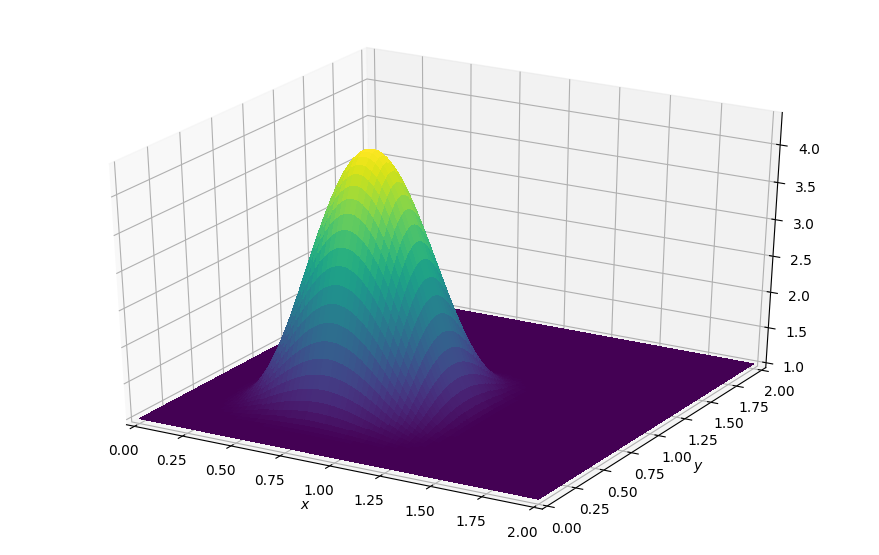

In [4]:
from devito import TimeData

u = TimeData(name='u', shape=(nx, ny))
init_smooth(field=u.data[0], dx=dx, dy=dy)

plot_field(u.data[0])

Nice. Now we can look at deriving our 3-point stencil using the symbolic capabilities given to our function $u$ by SymPy. For this we will first construct our derivative terms in space and time. For the forward derivative in time we can easily use Devito's shorthand notation `u.dt` to denote the first derivative in time and `u.dxl` and `u.dyl` to denote the space derivatives. Note that the `l` means were using the "left" or backward difference here to adhere to the discretization used in the original tutorials.

From the resulting terms we can then create a `sympy.Equation` object that contains the fully discretised equation, but from a neat high-level notation, as shown below.

In [5]:
from sympy import Eq

eq = Eq(u.dt + c*u.dxl + c*u.dyl)

print(eq)

Eq(-u(t, x, y)/s + u(t + s, x, y)/s + 2.0*u(t, x, y)/h - 1.0*u(t, x, y - h)/h - 1.0*u(t, x - h, y)/h, 0)


The above step resulted in a fully discretised version of our equation, which includes place-holder symbols for the spacing in time (`s`) and space (`h`). These symbols are based on an internal convention and will later be replaced when we build an operator.

But before we can build an operator, we first need to change our discretised expression so that we are updating the forward stencil point in our timestepping scheme - Devito provides another short-hand notation for this: `u.forward`. For the actual symoblic reordering, SymPy comes to the rescue with the `solve` utility that we can use to re-organise our equation.

In [6]:
from sympy import solve

stencil = solve(eq, u.forward)[0]

print(stencil)

(h*u(t, x, y) - 2.0*s*u(t, x, y) + s*u(t, x, y - h) + s*u(t, x - h, y))/h


The careful reader will note that this is now the equivalent symbolic expression to the RHS term of the NumPy code we showed earlier - only with `dx` and `dy` denoted as `h` and `dt` denoted as `s`, while `u(t, x, y)`, `u(t, x - h, y)` and `u(t, x, y - h)` denote the equivalent of $u^{n}_{i, j}$, $u^{n}_{i-1, j}$ and $u^{n}_{i, j-1}$ respectively. 

We can now use this stencil expression to create an operator to apply to our data object:

DSE: extract_time_invariants [flops: 5, elapsed: 0.00] >>
     eliminate_inter_stencil_redundancies [flops: 5, elapsed: 0.00] >>
     eliminate_intra_stencil_redundancies [flops: 5, elapsed: 0.00] >>
     factorize [flops: 4, elapsed: 0.00] >>
     finalize [flops: 4, elapsed: 0.00]
     [Total elapsed: 0.01 s]
DLE: analyze [elapsed: 0.00] >>
     avoid_denormals [elapsed: 0.00] >>
     loop_fission [elapsed: 0.00] >>
     create_elemental_functions [elapsed: 0.00] >>
     loop_blocking [elapsed: 0.01] >>
     simdize [elapsed: 0.15]
     [Total elapsed: 0.17 s]
CustomCompiler: compiled /var/folders/3l/2zfpyh3n5c357t10vpx38ygm0000gn/T/devito-501/6aaf870464b3b177e4afd85a712be00325a70519.c [0.68 s]
Section main<101,80,80> with OI=0.49 computed in 0.000 s [Perf: 7.93 GFlops/s]


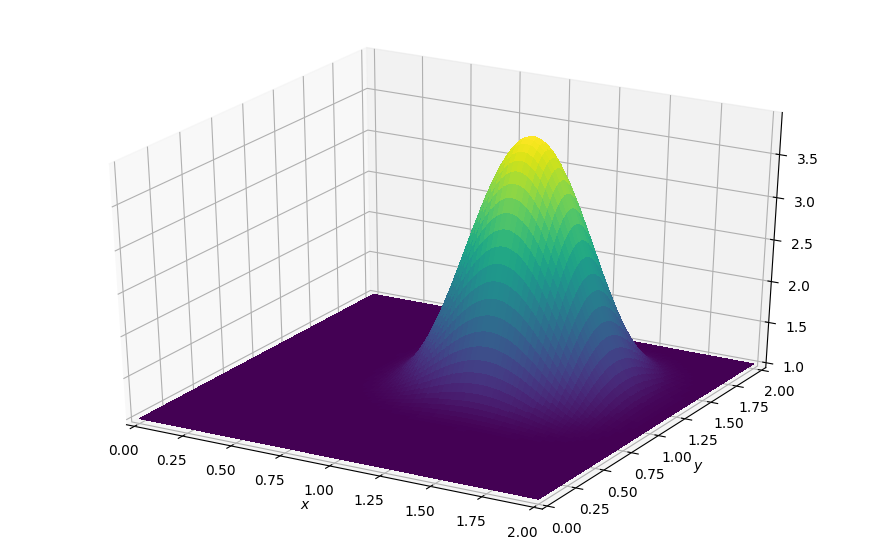

In [7]:
from sympy.abc import h, s
from devito import Operator, time

# Reset our initial condition in both buffers.
# This is required to avoid 0s propagating into
# our solution, which has a background value of 1.
init_smooth(field=u.data[0], dx=dx, dy=dy)
init_smooth(field=u.data[1], dx=dx, dy=dy)

# Create an operator that updates the forward stencil point
op = Operator(Eq(u.forward, stencil), subs={h: dx, s:dt})

# Apply the operator for a number of timesteps
op(time=nt+1)

plot_field(u.data[0, :, :])

# Some small sanity checks for the testing framework
assert (u.data[0, 45:55, 45:55] > 1.8).all()
assert np.allclose(u.data[0], u_ref, rtol=3.e-2)

Great, that looks to have done the same thing as the original NumPy example, so we seem to be doing something right, at least.

**A note on performance:** During the code generation phase of the previous operatorm Devito has created some log output with information about two optimisation steps: The DSE (Devito Symbolics Engine) and the DLE (Devito Loop Engine). We can ignore these for now, because our exmaple is tiny - but for large runs where performance matters, these are the engines that make the Devito kernel run very fast in comparison to raw Python/NumPy.

Now, despite getting a correct looking result, there is still one problem with the above operator: It doesn't set any boundary conditions as part of the time loop. We also note that the operator includes a time loop, but at this point Devito doesn;t actually provide any language constructs to explicitly define different types of boundary conditions (Devito is probably still a kind of prototype at this point). Luckily though, Devito provides a backdoor for us to insert custom expression in the so-called "indexed" or "low-level" API that allow us to encode the Dirichlet boundary condition of the original example.

#### The "indexed" or low-level API
The `TimeData` field we created earlier behaves symbolically like a `sympy.Function` object with the appropriate indices, eg. `u(t, x, y)`. If we take a simple first-order derivative of that we have a term that includes the spacing variable `h`, which Devito uses as the default for encoding $dx$ or $dy$. For example, `u.dx` simply expands to `-u(t, x, y)/h + u(t, x + h, y)/h`.

Now, when the `Operator` creates explicit C-code from that expression, it at some point "lowers" that expression by resolving explicit data accesses (or indices) into our grid by transforming it into a `sympy.Indexed` object. During this process all occurences of `h` in data accesses get replaced with integers, so that the expression now looks like `-u[t, x, y]/h + u[t, x + 1, y]/h`. This is the "indexed" notation and we can create custom expression of the same kind by using the `u.indexed` property with explicit indices in square-bracket notation. These custom expressions can then be injected them into our operator like this:

CustomCompiler: compiled /var/folders/3l/2zfpyh3n5c357t10vpx38ygm0000gn/T/devito-501/79af1d1041662300b14c729f097a980d80c1827a.c [0.12 s]
Section loop_y_1<101,81> with OI=0.00 computed in 0.000 s [Perf: 0.00 GFlops/s]
Section loop_x_2<101,81> with OI=0.00 computed in 0.000 s [Perf: 0.00 GFlops/s]
Section main<101,80,80> with OI=0.61 computed in 0.000 s [Perf: 13.14 GFlops/s]


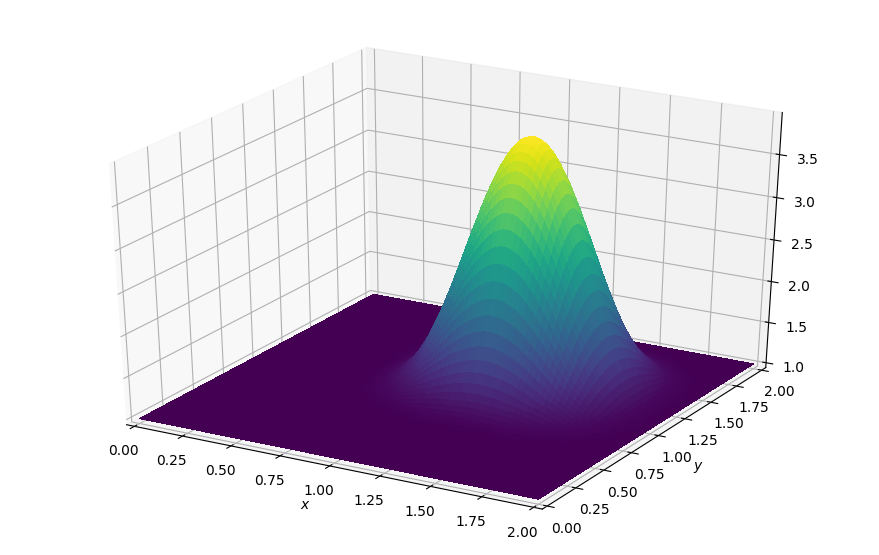

In [8]:
from devito import t, x, y

# Reset our data field and ICs in both buffers
init_smooth(field=u.data[0], dx=dx, dy=dy)
init_smooth(field=u.data[1], dx=dx, dy=dy)

# For defining BCs, we want to explicitly set rows/columns in our field
# We can use Devito's "indexed" notation to do this:
bc_left = Eq(u.indexed[t + 1, 0, y], 1.)
bc_right = Eq(u.indexed[t + 1, nx-1, y], 1.)
bc_top = Eq(u.indexed[t + 1, x, ny-1], 1.)
bc_bottom = Eq(u.indexed[t + 1, x, 0], 1.)

# Now combine the BC expressions with the stencil to form operator
expressions = [Eq(u.forward, stencil)]
expressions += [bc_left, bc_right, bc_top, bc_bottom]
op = Operator(expressions=expressions, subs={h: dx, s:dt},
              dle=None, dse=None)  # <-- Turn off performance optimisations
op(time=nt+1)

plot_field(u.data[0, :, :])

# Some small sanity checks for the testing framework
assert (u.data[0, 45:55, 45:55] > 1.8).all()
assert np.allclose(u.data[0], u_ref, rtol=3.e-2)

You might have noticed that we used the arguments `dle=None` and `dse=None` in the creation of the previous operator. This suppresses the various performance optimisation steps in the code-generation pipeline, which makes the auto-generated C code much easier to look at. So, for the brave, let's have a little peek under the hood... 

In [9]:
print(op.ccode)

#define _POSIX_C_SOURCE 200809L
#include "stdlib.h"
#include "math.h"
#include "sys/time.h"

struct profiler
{
  double loop_x_0;
  double loop_y_1;
  double loop_x_2;
} ;


int Kernel(float *restrict u_vec, const int t_size, const int x_size, const int y_size, const int time_size, struct profiler *timings)
{
  float (*restrict u)[x_size][y_size] __attribute__((aligned(64))) = (float (*)[x_size][y_size]) u_vec;
  for (int time = 0; time < time_size - 1; time += 1)
  {
    int t0 = (time) % 2;
    int t1 = (time + 1) % 2;
    struct timeval start_loop_x_0, end_loop_x_0;
    gettimeofday(&start_loop_x_0, NULL);
    for (int x = 1; x < x_size; x += 1)
    {
      for (int y = 1; y < y_size; y += 1)
      {
        u[t1][x][y] = 6.0e-1F*u[t0][x][y] + 2.0e-1F*u[t0][x][y - 1] + 2.0e-1F*u[t0][x - 1][y];
      }
    }
    gettimeofday(&end_loop_x_0, NULL);
    timings->loop_x_0 += (double)(end_loop_x_0.tv_sec-start_loop_x_0.tv_sec)+(double)(end_loop_x_0.tv_usec-start_loop_x_0.tv_usec)/1000000;